## Amazon Product Sentiment Analysis using VADER and RoBERTa

This project focuses on performing sentiment analysis on Amazon product reviews by leveraging two popular NLP models: RoBERTa, a deep learning transformer-based model, and VADER, a lexicon and rule-based model optimized for social media text. The objective is to classify review texts into three sentiment categories—positive, neutral, and negative—while comparing the performance and accuracy of each model. This study evaluates how each model handles different nuances in review sentiment, such as intense emotions or mixed feedback, using metrics like precision, recall, and F1-score.<br><br>

The results of this analysis provide insights into the strengths and weaknesses of transformer-based models versus traditional lexicon-based models in understanding customer sentiment within product reviews. This can help e-commerce platforms refine their review analysis tools to better gauge customer satisfaction and improve product recommendations.<br><br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('vader_lexicon')

plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('reviews_filtered.csv')

In [3]:
df_balance = pd.read_csv('reviews_balance.csv')
df_sample = pd.read_csv('reviews_sample.csv')

In [4]:
example = df['Text'][0]
example_score = df['Score'][0]
print(f'Text:  {example}\nScore: {example_score}')

Text:  I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Score: 5


In [5]:
example = df['Text'][0]

### Model 1: VADER (Valence Aware Dictionary and sEntiment Reasoner)

NLTK's SentimentIntensityAnalyzer obtains the neg/neu/pos scores of the text.<br>

The VADER model is a specialized sentiment analysis tool designed to analyze text, particularly in social media, by evaluating the sentiment expressed in a piece of text. It uses a lexicon of words that are associated with positive, negative, and neutral sentiments, allowing it to assign sentiment scores to texts based on the presence of these words and their context. VADER is particularly effective for short texts, such as product reviews, due to its ability to consider sentiment-laden terms and their modifiers (like "very" or "not").<br>

The VADER model is applied to each review in the datasets (`df_balance` and `df_sample`) to generate sentiment scores. Each score includes:

* Positive Score: Indicates the degree of positivity in the text.
* Negative Score: Indicates the degree of negativity in the text.
* Neutral Score: Indicates the degree of neutrality in the text.
* Compound Score: A normalized score ranging from -1 (most negative) to +1 (most positive) that summarizes the overall sentiment.

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [7]:
sia = SentimentIntensityAnalyzer()
vader_score = sia.polarity_scores(example)
actual_score = df['Score'].iloc[0]

In this example, the VADER model accounted for 69.5% neutrality and 30.5% positivity. A high neutral score is a weakness in the VADER model with it's inability to understand the emotion behind the text and relationships between words. However, having compound be 0.924 assumes that this review is mostly positive.

In [8]:
print(f'Review Text: {example}\nVader Score: {vader_score}\nActual Score: {actual_score}')

Review Text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Vader Score: {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}
Actual Score: 5


In [9]:
results = {}

for i, row in tqdm(df_balance.iterrows(), total=len(df_balance)):
    text = row['Text']
    id = row['Id']
    results[id] = sia.polarity_scores(text)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [10]:
df_vader_balance = pd.DataFrame(results).T
df_vader_balance = df_vader_balance.reset_index().rename(columns={'index':'Id'})
df_vader_balance

,Id,neg,neu,pos,compound
0,12285,0.114,0.744,0.142,0.4976
1,190572,0.058,0.831,0.111,0.1531
2,220728,0.113,0.839,0.047,-0.5574
3,510421,0.064,0.832,0.103,0.9127
4,567952,0.000,0.667,0.333,0.9681
...,...,...,...,...,...
1495,543113,0.000,0.699,0.301,0.8805
1496,540138,0.041,0.592,0.367,0.9700
1497,547668,0.079,0.633,0.288,0.9627
1498,419208,0.074,0.825,0.101,0.0772


In [11]:
df_vader_balance = df_vader_balance.merge(df_balance, how='left')
df_vader_balance.head(1)

,Id,neg,neu,pos,compound,Score,Text,TrueLabel
0,12285,0.114,0.744,0.142,0.4976,1,These had been my dog's favorite treats. BUT w...,negative


In [12]:
df_vader_balance['VaderLabel'] = df_vader_balance['compound'].apply(lambda x: 'positive' if x >= 0.05
                                                    else ('negative' if x <= -0.05 else 'neutral'))


In [13]:
df_vader_balance.head(1)

,Id,neg,neu,pos,compound,Score,Text,TrueLabel,VaderLabel
0,12285,0.114,0.744,0.142,0.4976,1,These had been my dog's favorite treats. BUT w...,negative,positive


In [14]:
results = {}

for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    text = row['Text']
    id = row['Id']
    results[id] = sia.polarity_scores(text)


  0%|          | 0/1500 [00:00<?, ?it/s]

In [15]:
df_vader_sample = pd.DataFrame(results).T
df_vader_sample = df_vader_sample.reset_index().rename(columns={'index':'Id'})
df_vader_sample

,Id,neg,neu,pos,compound
0,183524,0.015,0.748,0.236,0.9642
1,264043,0.019,0.905,0.077,0.8641
2,356974,0.094,0.557,0.350,0.9586
3,348928,0.119,0.727,0.155,0.5719
4,5081,0.000,0.793,0.207,0.9568
...,...,...,...,...,...
1495,491449,0.000,0.670,0.330,0.9300
1496,167803,0.000,0.903,0.097,0.3291
1497,368965,0.032,0.702,0.266,0.9358
1498,419663,0.162,0.654,0.184,-0.1117


In [16]:
df_vader_sample = df_vader_sample.merge(df_sample, how='left')
df_vader_sample.head(1)

,Id,neg,neu,pos,compound,Score,Text,TrueLabel
0,183524,0.015,0.748,0.236,0.9642,5,We really liked these cookies! While we were ...,positive


In [17]:
df_vader_sample['VaderLabel'] = df_vader_sample['compound'].apply(lambda x: 'positive' if x >= 0.05
                                                    else ('negative' if x <= -0.05 else 'neutral'))


In [18]:
df_vader_sample.head(1)

,Id,neg,neu,pos,compound,Score,Text,TrueLabel,VaderLabel
0,183524,0.015,0.748,0.236,0.9642,5,We really liked these cookies! While we were ...,positive,positive


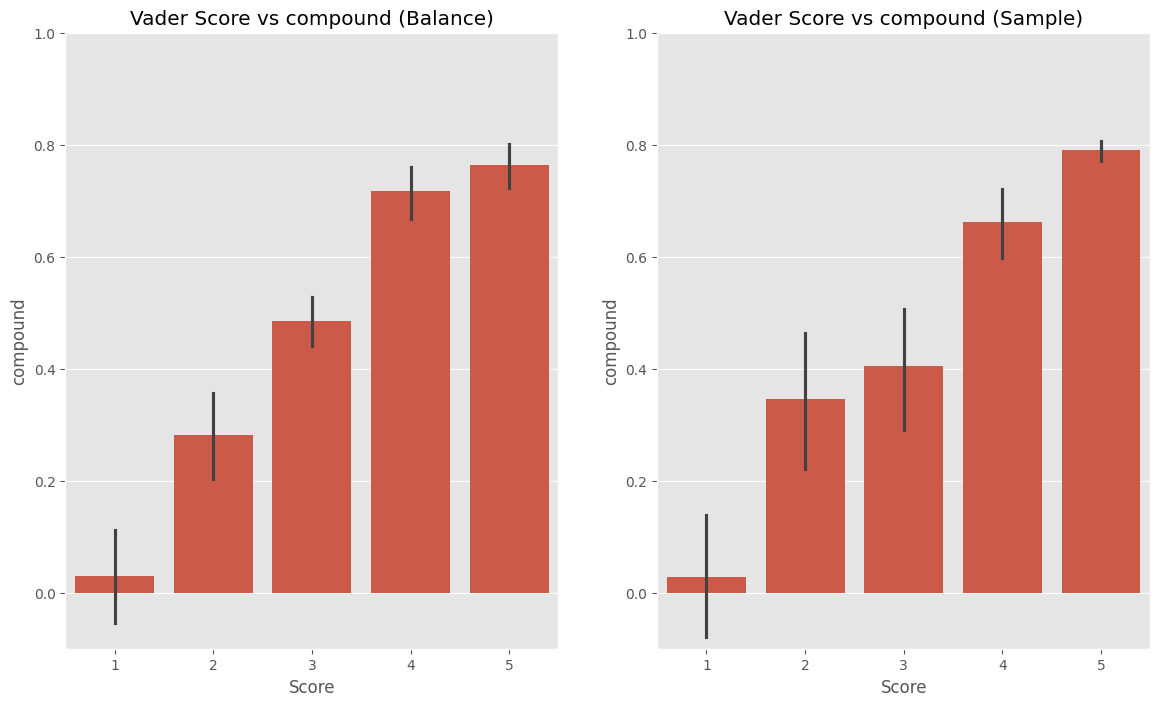

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14,8))

sns.barplot(data=df_vader_balance, ax=ax[0], x='Score', y='compound')
ax[0].set_ylim(-0.1, 1)
ax[0].set_title('Vader Score vs compound (Balance)')

sns.barplot(data=df_vader_sample, ax=ax[1], x='Score', y='compound')
ax[1].set_ylim(-0.1, 1)
ax[1].set_title('Vader Score vs compound (Sample)')
plt.show()

The average compound score in both the balanced and sample datasets increase as the Score increases.

In [20]:
df_vader_pivot = pd.concat([df_vader_balance, df_vader_sample])

df_vader_pivot_1 = df_vader_pivot.pivot_table(values=['neu', 'compound'],
                                             index='Score',
                                             aggfunc='mean')
df_vader_pivot_2 = df_vader_pivot.pivot_table(values=['neg', 'pos'],
                                             index='Score',
                                             aggfunc='mean')

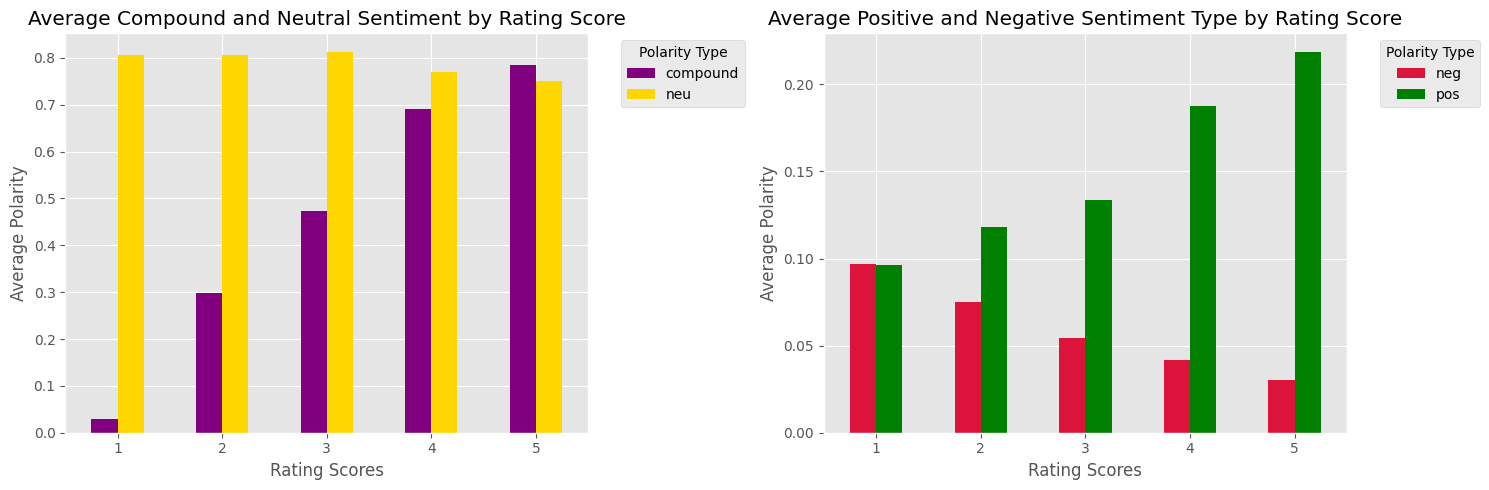

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

df_vader_pivot_1.plot.bar(ax=ax[0], xlabel='Rating Scores', ylabel='Average Polarity', rot=0, figsize=(15,5),
                          color=['purple', 'gold'])
ax[0].legend(bbox_to_anchor=(1.05, 1), title='Polarity Type')
ax[0].set_title('Average Compound and Neutral Sentiment by Rating Score')

df_vader_pivot_2.plot.bar(ax=ax[1], xlabel='Rating Scores', ylabel='Average Polarity', rot=0, figsize=(15,5),
                          color=['crimson', 'green'])
ax[1].legend(bbox_to_anchor=(1.05, 1), title='Polarity Type')
ax[1].set_title('Average Positive and Negative Sentiment Type by Rating Score')

plt.tight_layout()
plt.show()

On the left graph, the average compound score increases as the Rating Scores increase, which is expected. However, the neutral score seems to remain flat.<br><br>
On the right graph, the average negative polarity decreases as the Rating Scores increase, and the average positive polarity increases as the Rating Scores increase, which is also expected.

#### **Analysis of False Positives and False Negative Reviews with the Vader Model**

In [22]:
vader_reviews = pd.concat([df_vader_balance, df_vader_sample])

**False Positive Review from VADER Model**

The text presents a humorous and scarcastic remarks about the product. While this reviewer expresses disappointment in its taste and texture, the reviewer shifts alternate uses of the product while being scarcastic. The Vader model was not able to pick up on the scarcasm and labeled the overall sentiment to be positive even though the reviewer gave the product one star.

In [23]:
# False positive review with the highest Vader Score

vader_FP = vader_reviews[(vader_reviews['Score']==1) &
                             (vader_reviews['VaderLabel']=='positive')] \
                             .sort_values('compound', ascending=False)
print(f"Text:  {vader_FP['Text'].iloc[0]}")
print(f"Label: {vader_FP['VaderLabel'].iloc[0]}")
print(f"Score: {vader_FP['Score'].iloc[0]}")

Text:  My husband always said that the two greatest inventions were duct tape, and WD-40, and many people share this view. Now add to this gg crispbread!!! Some people say they make great sandwiches with peanut butter, tuna salad, or cheese, I even heard they make good pizzas, so I tried these. I didn't like any of them, but not wanting to waste my money, I decided to try some other ways of enjoying these. They really are wonderful after all!!! Throw them on the pond and they make wonderful little rafts for the frogs to sunbathe on, even baby turtles will enjoy a nice sun bath on them!  Why not use them to repair holes in the barn where the grand children decided to try out the old brace and bit and drilled holes? I know mice chew through wood, but believe me it is going to take them awhile to chew through these! Cigarette burn on your coffee table? Just sand it down with with these rough little squares, {Just finish with a fine sandpaper to smooth out the roughness) and re-stain. Glue

**False Negative Review with VADER Model**

The text conveys a neutral sentiment about the trap being reviewed. Although the reviewer states that this specific trap works as well as others they have used for years, the overall label is negative. Although the sentiment of this review is not positive, it does not align with the 5 star rating. The reviewer must've been satisfied with the product, but the sentiment of the review was not positive.

In [24]:
# False negative review with the highest Vader Score

vader_FN = vader_reviews[(vader_reviews['Score']==5) &
             (vader_reviews['VaderLabel']=='negative')] \
                    .sort_values('compound', ascending=False)
print(f"Text:  {vader_FN['Text'].iloc[0]}")
print(f"Label: {vader_FN['VaderLabel'].iloc[0]}")
print(f"Score: {vader_FN['Score'].iloc[0]}")

Text:  I have used this type of trap for years, and this one works just as well as any others I have owned.
Label: negative
Score: 5


### Model 2: ROBERTA

The RoBERTa model, a refined version of BERT (Bidirectional Encoder Representations from Transformers), is a transformer-based model developed by Facebook AI for improved natural language understanding. Trained on a larger corpus and using a more robust pretraining process than BERT, RoBERTa excels at tasks like sentiment analysis, where it can capture nuanced language patterns, context, and subtle cues in text.<br>

For the Amazon product review dataset, the RoBERTa pre-trained model `cardiffnlp/twitter-roberta-base-sentiment` is used to classify reviews as positive, neutral, or negative. By processing each review through RoBERTa’s tokenizer and sequence classification layers, the model generates sentiment scores that can reveal overall customer satisfaction. These insights are useful for understanding customer preferences, identifying potential product issues, and guiding business decisions based on customer feedback.

In [25]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore', message='The secret `HF_TOKEN` does not exist in your Colab secrets')

In [26]:
model_name = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

device = torch.device("cpu")
model.to(device)

encoded_text = tokenizer(example, return_tensors='pt')

with torch.no_grad():
    output = model(**encoded_text)

logits = output.logits

scores = softmax(logits.numpy())[0].round(6)

roberta_scores = {
    'neg': scores[0],
    'neu': scores[1],
    'pos': scores[2]
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The sentiment analysis suggests a strong positive sentiment, aligning well with the actual score of 5, indicating satisfaction with the product. The positive score is overwhelmingly higher than the negative and neutral score.

In [27]:
print(f'Review Text: {text}\nRoberta Score: {roberta_scores}\nActual Score: {actual_score}')

Review Text: These bowls are the dimensions stated, but not what may seem "small."  That said, good quality.  Wet food sticks, so need to clean frequently.  We use these actually for our cats; it slows them down, but also tends to make a mess with scraps outside the bowl-- better than vomit, though!
Roberta Score: {'neg': 0.009624, 'neu': 0.04998, 'pos': 0.940395}
Actual Score: 5


In [28]:
# Defining appropriate parameters for the transformer's sentiment-analysis pipeline
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
sentiment_pipeline = pipeline('sentiment-analysis', f"cardiffnlp/twitter-roberta-base-sentiment",
                              tokenizer=tokenizer)

# Defining get_sentement function to rename the original labels to 'negative', 'neutral', and 'positive'
def get_sentiment(text):
    result = sentiment_pipeline(text)
    label_map = {'LABEL_0': 'negative',
                 'LABEL_1': 'neutral',
                 'LABEL_2': 'positive'}
    result[0]['label'] = label_map[result[0]['label']]
    return result[0]

In [29]:
# RoBERTa model for the balanced dataset
results = []
for i, text in tqdm(enumerate(df_balance['Text']), total= len(df_balance), desc="Analyzing Sentiments"):
    try:
        id = df_balance['Id'].iloc[i]
        sentiment_result = get_sentiment(text)
        sentiment_result['Id'] = id
        results.append(sentiment_result)

    except RuntimeError:
        print(f'Broke for id: {id}')

Analyzing Sentiments:   0%|          | 0/1500 [00:00<?, ?it/s]

In [30]:
df_roberta_balance = pd.DataFrame(results)
df_roberta_balance = df_roberta_balance.merge(df_balance, how='left')
df_roberta_balance = df_roberta_balance.rename(columns={'label':'RobertaLabel', 'score':'RobertaScore'})
df_roberta_balance.shape

(1500, 6)

In [31]:
# RoBERTa model for the sample dataset
results = []
for i, text in tqdm(enumerate(df_sample['Text']), total= len(df_sample), desc="Analyzing Sentiments"):
    try:
        id = df_sample['Id'].iloc[i]
        sentiment_result = get_sentiment(text)
        sentiment_result['Id'] = id
        results.append(sentiment_result)

    except RuntimeError:
        print(f'Broke for id: {id}')

Analyzing Sentiments:   0%|          | 0/1500 [00:00<?, ?it/s]

In [32]:
df_roberta_sample = pd.DataFrame(results)
df_roberta_sample = df_roberta_sample.merge(df_sample, how='left')
df_roberta_sample = df_roberta_sample.rename(columns={'label':'RobertaLabel', 'score':'RobertaScore'})
df_roberta_sample.shape

(1500, 6)

**False Positive RoBERTa Reviews**

In [33]:
roberta_reviews = pd.concat([df_roberta_balance, df_roberta_sample])

The text expresses the reviewer’s enjoyment of a particular coffee brand, highlighting its taste, convenience, and reasonable pricing. They appreciate the hazelnut flavor and compare it favorably to freshly brewed coffee. The reviewer requests the return of the product, indicating their strong preference for it. The label is marked as "positive," aligning with the enthusiastic sentiment conveyed. But the reviewer must've given a 1 star review since the product is not available on Amazon.

In [34]:
# False positive review with the highest Roberta Score

roberta_FP = roberta_reviews[(roberta_reviews['Score']==1) &
                             (roberta_reviews['RobertaLabel']=='positive')] \
                             .sort_values('RobertaScore', ascending=False)
print(f"Text:  {roberta_FP['Text'].iloc[0]}")
print(f"Label: {roberta_FP['RobertaLabel'].iloc[0]}")
print(f"Score: {roberta_FP['Score'].iloc[0]}")

Text:  I have enjoyed this coffee in the canisters for years, and have found it just as good as freshly brewed coffee with a wonderful hazelnut flavor.  The canisters are so convenient and reasonably priced.  Please bring them back.
Label: positive
Score: 1


The text describes a customer's disappointment with the new formula of HappyBaby's Super Salmon product. The reviewer emphasizes their dissatisfaction, noting that the new version has less protein and more sugar and sodium compared to the old formula, which their child loved. The reviewer concludes that they will not purchase the product again. Despite the strong negative sentiment conveyed, it is incorrectly labeled as "positive," suggesting a possible inconsistency in labeling or interpretation.

In [35]:
# False positive review with the lowest Roberta Score

roberta_FP = roberta_reviews[(roberta_reviews['Score']==1) &
                             (roberta_reviews['RobertaLabel']=='positive')] \
                             .sort_values('RobertaScore')
print(f"Text:  {roberta_FP['Text'].iloc[0]}")
print(f"Label: {roberta_FP['RobertaLabel'].iloc[0]}")
print(f"Score: {roberta_FP['Score'].iloc[0]}")

Text:  Was so disappointed to discover that HappyBaby changed Super Salmon!  My little girl LOVED the old formula, and it had more protein and calories than this new version.  The new version also has more sugar and sodium than the previous version, and it has a completely different taste and texture - she won't touch it.  We will not be buying it again.
Label: positive
Score: 1


**False Negative RoBERTa Review**

The text describes a mixed experience with Popchips Original Potato Chips. The reviewer finds the chips delicious and acknowledges that their children enjoy them as well. However, they express disappointment after discovering that the chips contain soy, which caused them a bad reaction due to their sensitivity. The label of "negative" seems fitting as the reviewer emphasizes their inability to enjoy the product despite liking its taste. However, the reviewer must've given a 5 since they did like the taste, and their children liked the taste.

In [37]:
# False negative review with the lowest Roberta Score

roberta_FN = roberta_reviews[(roberta_reviews['Score']==5) &
                    (roberta_reviews['RobertaLabel']=='negative')] \
                    .sort_values('RobertaScore')
print(f"Text:  {roberta_FN['Text'].iloc[0]}")
print(f"Label: {roberta_FN['RobertaLabel'].iloc[0]}")
print(f"Score: {roberta_FN['Score'].iloc[0]}")

Text:  Popchips Original Potato Chips are dee-lish.  But BEWARE of the SOY in them if you have a soy sensitivity, like I do.  I ate quite a few and had a bad reaction before reading the label and realizing that soy was an ingredient.  I just never imagined soy would be in a potato chip!  I learned my lesson!  My kids love the chips and, I agree, they are YUMMY!  I'm sad that I can't have them!  :-(
Label: negative
Score: 5


### Comparison

**RoBERTa** excels in identifying the highly positive sentiment, reflecting the reviewer’s satisfaction more accurately than VADER.<br><br>
**VADER** identifies a strong positive sentiment overall (through the compound score) but treats much of the text as neutral, possibly missing the strong positive sentiment due to its rule-based approach.<br><br>
In the example review below, RoBERTa’s output is more aligned with the actual score of 5, as it captures the highly favorable tone in the review. VADER’s output suggests a mixed sentiment but does register an overall positive sentiment through its compound score.

In [38]:
print(f'Review Text: {example}\nActual Score: {actual_score}\n')
print(f'Roberta Score: {roberta_scores}\nVader Score:   {vader_score}')

Review Text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Actual Score: 5

Roberta Score: {'neg': 0.009624, 'neu': 0.04998, 'pos': 0.940395}
Vader Score:   {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}


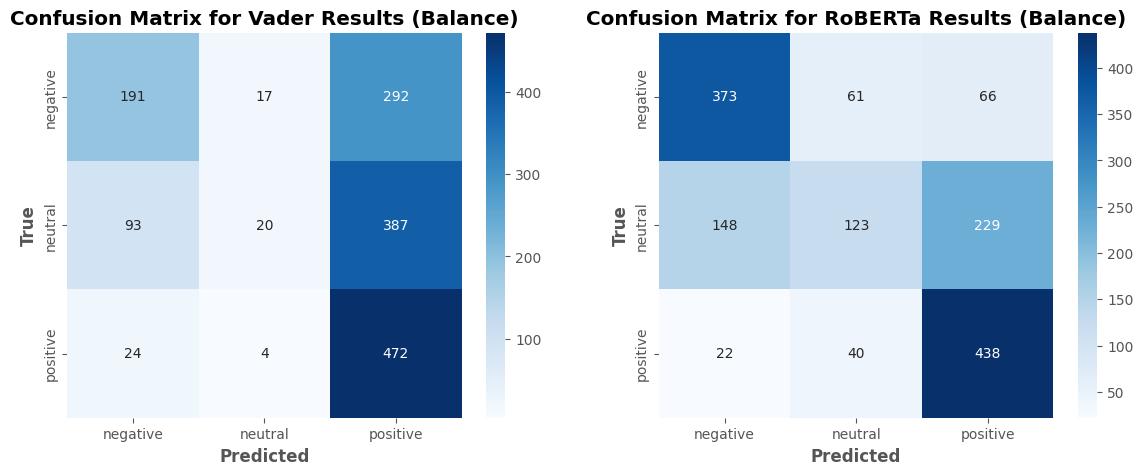

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

cm_vader = confusion_matrix(df_vader_balance['TrueLabel'], df_vader_balance['VaderLabel'])

sns.heatmap(cm_vader, ax=ax[0], annot=True, fmt='d', cmap='Blues',
            xticklabels=df_vader_balance['TrueLabel'].unique(),
            yticklabels=df_vader_balance['TrueLabel'].unique())
ax[0].set_xlabel('Predicted', fontweight='bold')
ax[0].set_ylabel('True', fontweight='bold')
ax[0].set_title('Confusion Matrix for Vader Results (Balance)', fontweight='bold')

cm_roberta = confusion_matrix(df_roberta_balance['TrueLabel'], df_roberta_balance['RobertaLabel'])

sns.heatmap(cm_roberta, ax=ax[1], annot=True, fmt='d', cmap='Blues',
            xticklabels=df_roberta_balance['TrueLabel'].unique(),
            yticklabels=df_roberta_balance['TrueLabel'].unique())
ax[1].set_xlabel('Predicted', fontweight='bold')
ax[1].set_ylabel('True', fontweight='bold')
ax[1].set_title('Confusion Matrix for RoBERTa Results (Balance)', fontweight='bold')

plt.show()

In [42]:
print('Classification Report for Vader Results (Balance)')
print(classification_report(df_vader_balance['TrueLabel'], df_vader_balance['VaderLabel'],
                            target_names=['negative', 'neutral', 'positive']))

print('Classification Report for RoBERTa Results (Balance)')
print(classification_report(df_roberta_balance['TrueLabel'], df_roberta_balance['RobertaLabel'],
                            target_names=['negative', 'neutral', 'positive']))

Classification Report for Vader Results (Balance)
              precision    recall  f1-score   support

    negative       0.62      0.38      0.47       500
     neutral       0.49      0.04      0.07       500
    positive       0.41      0.94      0.57       500

    accuracy                           0.46      1500
   macro avg       0.51      0.46      0.37      1500
weighted avg       0.51      0.46      0.37      1500

Classification Report for RoBERTa Results (Balance)
              precision    recall  f1-score   support

    negative       0.69      0.75      0.72       500
     neutral       0.55      0.25      0.34       500
    positive       0.60      0.88      0.71       500

    accuracy                           0.62      1500
   macro avg       0.61      0.62      0.59      1500
weighted avg       0.61      0.62      0.59      1500



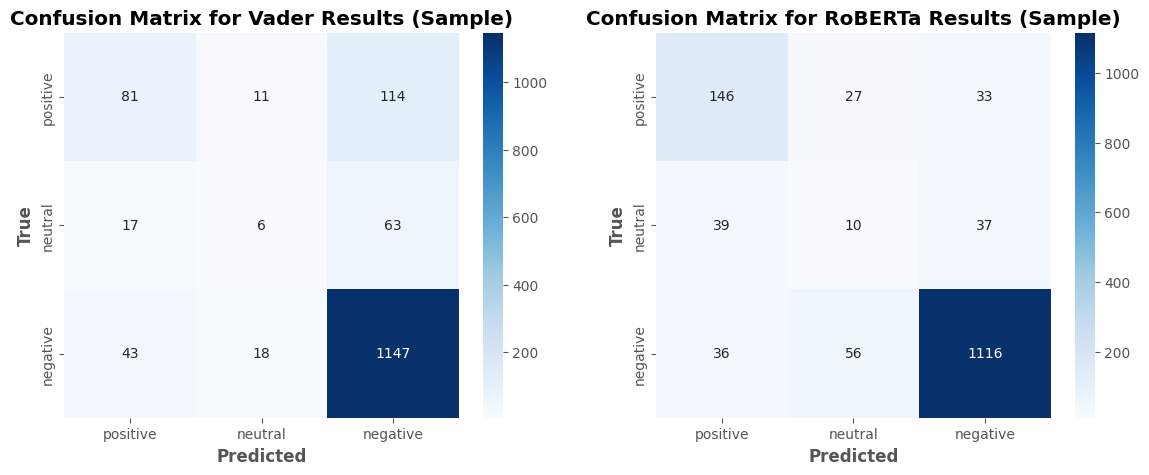

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))


cm_vader = confusion_matrix(df_vader_sample['TrueLabel'], df_vader_sample['VaderLabel'])

sns.heatmap(cm_vader, ax=ax[0], annot=True, fmt='d', cmap='Blues',
            xticklabels=df_vader_sample['TrueLabel'].unique(),
            yticklabels=df_vader_sample['TrueLabel'].unique())
ax[0].set_xlabel('Predicted', fontweight='bold')
ax[0].set_ylabel('True', fontweight='bold')
ax[0].set_title('Confusion Matrix for Vader Results (Sample)', fontweight='bold')

cm_roberta = confusion_matrix(df_roberta_sample['TrueLabel'], df_roberta_sample['RobertaLabel'])

sns.heatmap(cm_roberta, ax=ax[1], annot=True, fmt='d', cmap='Blues',
            xticklabels=df_roberta_sample['TrueLabel'].unique(),
            yticklabels=df_roberta_sample['TrueLabel'].unique())
ax[1].set_xlabel('Predicted', fontweight='bold')
ax[1].set_ylabel('True', fontweight='bold')
ax[1].set_title('Confusion Matrix for RoBERTa Results (Sample)', fontweight='bold')

plt.show()

In [44]:
print('\nClassification Report for Vader Results (Sample)')
print(classification_report(df_vader_sample['TrueLabel'], df_vader_sample['VaderLabel'],
                            target_names=['negative', 'neutral', 'positive']))

print('\nClassification Report for RoBERTa Results (Sample)')
print(classification_report(df_roberta_sample['TrueLabel'], df_roberta_sample['RobertaLabel'],
                            target_names=['negative', 'neutral', 'positive']))


Classification Report for Vader Results (Sample)
              precision    recall  f1-score   support

    negative       0.57      0.39      0.47       206
     neutral       0.17      0.07      0.10        86
    positive       0.87      0.95      0.91      1208

    accuracy                           0.82      1500
   macro avg       0.54      0.47      0.49      1500
weighted avg       0.79      0.82      0.80      1500


Classification Report for RoBERTa Results (Sample)
              precision    recall  f1-score   support

    negative       0.66      0.71      0.68       206
     neutral       0.11      0.12      0.11        86
    positive       0.94      0.92      0.93      1208

    accuracy                           0.85      1500
   macro avg       0.57      0.58      0.58      1500
weighted avg       0.85      0.85      0.85      1500



### Conclusion

The classification reports for VADER and RoBERTa on the balanced and sampled Amazon product datasets reveal distinct strengths and limitations for each model:<br>

**VADER Performance**:<br>

**Balanced Dataset**: VADER struggles with neutral reviews, achieving low precision, recall, and F1-scores, suggesting difficulty in detecting moderately toned sentiments. Positive sentiment, however, shows a high recall but at the cost of lower precision, indicating that VADER may overclassify reviews as positive.<br>
**Sampled Dataset**: VADER's performance on the imbalanced sample shows high precision and recall for positive sentiment but limited ability to differentiate neutral reviews, evident in the significant drop in F1-score. Accuracy is higher due to the model’s positive sentiment bias, likely due to the large number of positive samples.<br><br>

**RoBERTa Performance**:

**Balanced Dataset**: RoBERTa generally outperforms VADER, especially in detecting negative and positive sentiments with stronger precision and recall. However, it too struggles with neutral reviews, achieving only a modest F1-score. Accuracy of 62% shows it performs better than VADER overall.<br>
**Sampled Dataset**: RoBERTa’s precision and recall for positive and negative sentiments remain high, while its neutral detection remains challenging. The model achieves high accuracy here, aided by the abundance of positive samples.<br><br>

**Insights:**

**Neutral Detection**: Both models have trouble identifying neutral sentiment, with significantly lower F1-scores for neutral reviews across datasets. This suggests that detecting moderate sentiments is complex, possibly due to subtle language cues.<br>
**Impact of Dataset Imbalance**: In the sampled dataset, both models show an increase in overall accuracy, but this may mask challenges in identifying less frequent sentiments, such as neutral and negative. For a more balanced performance, additional training or fine-tuning on neutral-dominant data could be beneficial.<br>
**Conclusion**: RoBERTa provides a more robust classification than VADER on balanced data, especially for negative and positive reviews, but both models struggle with neutral sentiment, likely due to subtler language cues and dataset imbalance.